In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Import Necessary Libraries

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.autograd import Variable

## Prepare Data

In this project, we will train an LSTM model to predict stock price movements. Before we can build the "crystal ball" to predict the future, we need historical stock price data to train our deep learning model. To this end, we will query the Yahoo Finance stock data API.

In [3]:
# Settings
ticker = "VTI"
# project_folder = '/content/drive/MyDrive/Colab Notebooks/2024.12.08 Stock Price Forecasting'

In [4]:
try:
    data_raw = yf.download(ticker, period='5y', interval='1d', progress=False)
    # data_latest = yf.download("VTI", period='5d', interval='1m')
except Exception as e:
    print('ERROR:', e)

data_raw.dropna()
data_raw.tail()

YF.download() has changed argument auto_adjust default to True


Price,Close,High,Low,Open,Volume
Ticker,VTI,VTI,VTI,VTI,VTI
Date,,,,,
2025-02-24,294.410004,297.339996,293.890015,296.959991,4465400
2025-02-25,292.950012,294.829987,290.540009,294.399994,3509200
2025-02-26,293.049988,295.700012,291.869995,293.899994,2807300
2025-02-27,288.510010,294.790009,288.399994,294.339996,2747300
2025-02-28,292.959991,293.209991,287.350006,288.630005,3483700


In [5]:
data_raw.shape

(1257, 5)

Please note that we are using the **adjusted close** (??) field of Yahoo Finance's daily adjusted API to remove any artificial price turbulences due to stock splits and dividend payout events. It is generally considered an industry best practice to use split/dividend-adjusted prices instead of raw prices to model stock price movements.

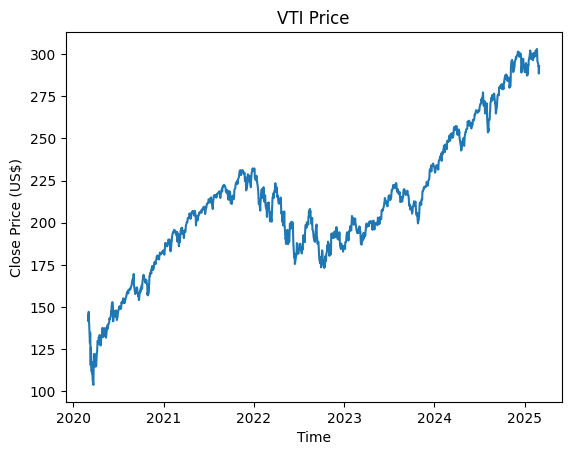

In [6]:
plt.plot(data_raw['Close'])
plt.title(f"{ticker} Price")
plt.xlabel ('Time')
plt.ylabel ('Close Price (US$)')
plt.show()

Consider to save data to a file.

In [7]:
# # Specify the path within your Google Drive
# path = f'{project_folder}/VTI_Stock.csv'

# # Save the data to Google Drive
# data.to_csv(path, index=False)

# # Load data from the file
# data = pd.read_csv(path)

## Preprocess Data

*   Add 20-day, 50-day moving average and RSI features to the dataframe.
*   Normalize the data using MinMaxScaler for better LSTM performance.



In [8]:
def add_features(data):
  data['Returns'] = data['Close'][ticker].pct_change()
  # Calculate 20-day moving average
  data['MA20'] = data['Close'][ticker].rolling(window=20).mean()
  data['MA50'] = data['Close'][ticker].rolling(window=50).mean()
  data['RSI'] = calculate_rsi(data['Close'][ticker])
  data['Volume_MA20'] = data['Volume'][ticker].rolling(window=20).mean()
  # Drop NaN values created by moving average
  return data.dropna()

def add_features2(data):
  data['Returns'] = data['Close'][ticker].diff()  # returns, differences between days
  data['RSI'] = calculate_rsi(data['Close'][ticker])
  data['Volume_MA20'] = data['Volume'][ticker].rolling(window=20).mean()
  # Drop NaN values created by moving average
  return data.dropna()

def calculate_rsi(prices, period=14):
  delta = prices.diff()
  gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
  loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
  rs = gain / loss
  return 100 - (100 / (1 + rs))

In [9]:
data_raw['Close'][ticker].head()

Date
2020-03-02    145.202225
2020-03-03    141.457962
2020-03-04    147.111465
2020-03-05    142.208664
2020-03-06    139.567276
Name: VTI, dtype: float64

Compute common indicators like moving averages (MA) and the Relative Strength Index (RSI) to capture the trends and momentum of the stock.

In [10]:
data = add_features(data_raw)
data2 = add_features2(data_raw)

In [11]:
data = data[["Close", "Returns", "MA20", "MA50", "RSI", "Volume_MA20"]]
no_features = data.shape[1]

data.tail()

Price,Close,Returns,MA20,MA50,RSI,Volume_MA20
Ticker,VTI,,,,,
Date,,,,,,
2025-02-24,294.410004,-0.005103,299.368002,296.555303,45.662470,3184980.0
2025-02-25,292.950012,-0.004959,299.160503,296.445715,37.500000,3094375.0
2025-02-26,293.049988,0.000341,298.830502,296.290082,33.726320,3098875.0
2025-02-27,288.510010,-0.015492,298.337503,296.077938,25.639955,3105230.0
2025-02-28,292.959991,0.015424,297.973503,295.957785,40.582915,3134855.0


### Normalizing raw data

Machine learning algorithms (such as our LSTM algorithm) that use gradient descent as the optimization technique require data to be scaled. This is due to the fact that the feature values in the model will affect the step size of the gradient descent, potentially skewing the LSTM model in unexpected ways.

This is where data normalization comes in. Normalization can increase the accuracy of your model and help the gradient descent algorithm converge more quickly towards the target minima. By bringing the input data on the same scale and reducing its variance, none of the weights in the artificial neural network will be wasted on normalizing tasks, which means the LSTM model can more efficiently learn from the data and store patterns in the network. Furthermore, LSTMs are intrinsically sensitive to the scale of the input data. For the above reasons, it is crucial to normalize the data.

Since stock prices can range from tens to hundreds and thousands - $40 to $160 in the case of IBM - we will perform normalization on the stock prices to standardize the range of these values before feeding the data to the LSTM model. The following code snippet rescales the data to have a mean of 0 and the standard deviation is 1.

Reference: https://github.com/jinglescode/time-series-forecasting-pytorch

In [12]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

### Generating training and validation datasets

Supervised machine learning methods such as LSTM learns the mapping function from input variables (X) to the output variable (Y). Learning from the training dataset can be thought of as a teacher supervising the learning process, where the teacher knows all the right answers.

In this project, we will train the model to **predict the 21st day price** based on the past 20 days' close prices. The number of days, 20, was selected based on a few reasons:

* When LSTM models are used in natural language processing, the number of words in a sentence typically ranges from 15 to 20 words
* Gradient descent considerations: attempting to back-propagate across very long input sequences may result in vanishing gradients
* Longer sequences tend to have much longer training times

After transforming the dataset into input features and output labels, the shape of our X is (5388, 20), 5388 for the number of rows, each row containing a sequence of past 20 days' prices. The corresponding Y data shape is  (5388,), which matches the number of rows in X.

In [13]:
# Split data into train and test sets
train_data, test_data = train_test_split(data_scaled, test_size=0.3, shuffle=False)
print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)

Train shape: (845, 6)
Test shape: (363, 6)


## Prepare Data for LSTM

Format the data into sequences for LSTM input.

In [14]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])  # Data of 20 days
        y.append(data[i + sequence_length][0])  # Predict the 'Close' price (column 0) of the 21st day
    print("Length: ", len(X))
    return np.array(X), np.array(y)

sequence_length = 20  # Use 20 days as a sequence
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

Length:  825
Length:  343


In [15]:
data2 = [[1, 'a'], [2, 'b'], [3, 'c'], [4, 'd'], [5, 'e'], [6, 'f']]

X_1, y_1 = create_sequences(data2, sequence_length=3)
print("Features:\n", X_1)
print("Target:", y_1)

Length:  3
Features:
 [[['1' 'a']
  ['2' 'b']
  ['3' 'c']]

 [['2' 'b']
  ['3' 'c']
  ['4' 'd']]

 [['3' 'c']
  ['4' 'd']
  ['5' 'e']]]
Target: [4 5 6]


In [16]:
y_train[-5:]

tensor([0.4978, 0.4980, 0.5088, 0.4938, 0.4939])

Instead, use DataLoader.

Traditional k-fold Cross-Validation doesn't work with time series data.
1. Temporal Dependencies: Stock prices are time-dependent, meaning past values influence future values. Traditional k-fold cross-validation would randomly split the data into folds, which disrupts this temporal order.

2. Data Leakage: If future data points are used in the training set to predict earlier data points (as can happen in k-fold CV), it introduces information that would not be available in real-world predictions, leading to overly optimistic performance estimates.

Apply **Walk-Forward Cross-Validation** (Rolling Window) for Time Series.
* The training set grows over time as the model is retrained on progressively larger portions of the data.
* The validation set always comes immediately after the training set in time.
* Example:
  * Fold 1: Train on t1...t100, validate on t101...t120.
  * Fold 2: Train on t1...t120, validate on t121...t140.
  * Fold 3: Train on t1...t140, validate on t141...t160.

This ensures predictions for each validation set are based only on past data.

In [17]:
from torch.utils.data import Dataset, Subset, DataLoader

class StockPriceDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        # Extract sequences and corresponding targets
        X = self.data[idx:idx + self.sequence_length, :]  # Features
        y = self.data[idx + self.sequence_length, 0]       # Target
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


def walk_forward_split(dataset, n_splits=5):
    """
    Generator for walk-forward validation splits.
    Args:
        dataset (Dataset): PyTorch Dataset object.
        n_splits (int): Number of validation splits.
    Yields:
        train_loader, val_loader: DataLoaders for train and validation sets.
    """
    batch_size = 32
    data_len = len(dataset)
    split_size = data_len // (n_splits + 1)  # Reserve the last split for testing

    for i in range(n_splits):
        train_end = (i + 1) * split_size
        val_start = train_end
        val_end = val_start + split_size

        # Create subsets for training and validation
        train_subset = Subset(dataset, list(range(0, train_end)))
        val_subset = Subset(dataset, list(range(val_start, val_end)))

        # DataLoaders for train and validation using *batch_size*
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        yield train_loader, val_loader

In [18]:

# Assuming 'processed_data' is your preprocessed NumPy array or DataFrame
train_dataset = StockPriceDataset(train_data, sequence_length=20)
# val_dataset = StockPriceDataset(test_data, sequence_length=20)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Define LSTM Model

Use an LSTM layer with dropout for regularization.

In [19]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=no_features, hidden_size=64, num_layers=1, dropout=0.2, output_size=1):
      # input_size = no_features ["Close", "Returns", "MA20", "MA50", "RSI", "Volume_MA20"]
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)  # output_size=1, it's the predicted price

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

## Train the Model

*   Define loss function and optimizer.
*   Train dataset has 341 items. Each item consists of features of 20 days and the target = the price of the 21st day.
*   Use **walk forward validation**, split train_data into train and validation data loaders.
*   Data in train and validation data loaders are organized in batches, each batch consists of 32 items --> there are 11 batches in total.
  * Fold 1: train_loader has batches 1-2, val_loader has batches 3-4
  * Fold 2: train_loader has batches 1-4, val_loader has batches 5-6
  * Fold 3: train_loader has batches 1-6, val_loader has batches 7-8
  * Fold 4: train_loader has batches 1-7, val_loader has batches 8-9
  * Fold 5: train_loader has batches 1-9, val_loader has batches 10-11

In [20]:
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# --> update learning rate, adaptive

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    train_val_splits = walk_forward_split(train_dataset, n_splits=5)

    for fold, (train_loader, val_loader) in enumerate(train_val_splits):
      # X_batch consists of several batches
      # each batch consists of 32 items
      # each item consists of 20 data points and 1 target value (price)
      for X_batch, y_batch in train_loader:
          outputs = model(X_batch)
          optimizer.zero_grad()
          loss = criterion(outputs.squeeze(), y_batch)
          loss.backward()
          optimizer.step()

      # Validation
      model.eval()
      with torch.no_grad():  # no model update
        val_loss = 0
        for X_batch, y_batch in val_loader:
          outputs = model(X_batch)
          val_loss += criterion(outputs.squeeze(), y_batch)

    if epoch == 0 or (epoch+1) % 10 == 0:
      print(f"Epoch {epoch+1}/{epochs}, Training Loss: {loss.item():.5f}, Val Loss: {val_loss:.5f}")  # val_loss / len(val_loader)

c:\TuanTA\ML Projects\ML-Projects\venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/50, Training Loss: 0.00121, Val Loss: 0.00641
Epoch 10/50, Training Loss: 0.00053, Val Loss: 0.00486
Epoch 20/50, Training Loss: 0.00091, Val Loss: 0.00806
Epoch 30/50, Training Loss: 0.00088, Val Loss: 0.00713
Epoch 40/50, Training Loss: 0.00077, Val Loss: 0.00606
Epoch 50/50, Training Loss: 0.00072, Val Loss: 0.00574


## Evaluate the Model

* We are not using DataLoader here.
* Evaluate on test data (X_test, y_test) and calculate MSE metric.

In [21]:
model.eval()
with torch.no_grad():
    predictions = model(X_test).squeeze()
    test_loss = criterion(predictions, y_test)
    print(f"Test Loss: {test_loss.item():.5f}")

Test Loss: 0.00867


In [22]:
scale_copy = MinMaxScaler()
scale_copy.min_, scale_copy.scale_ = scaler.min_[0], scaler.scale_[0]
# Inverse transform the scaled data
predicted_prices = scale_copy.inverse_transform(predictions.numpy().reshape(-1, 1))
actual_prices = scale_copy.inverse_transform(y_test.reshape(-1, 1))

print(predicted_prices[-5:])
print(actual_prices[-5:])


[[274.24002]
 [273.4624 ]
 [272.4089 ]
 [272.21344]
 [268.68347]]
[[294.41000762]
 [292.95001473]
 [293.049985  ]
 [288.51000488]
 [292.95999439]]


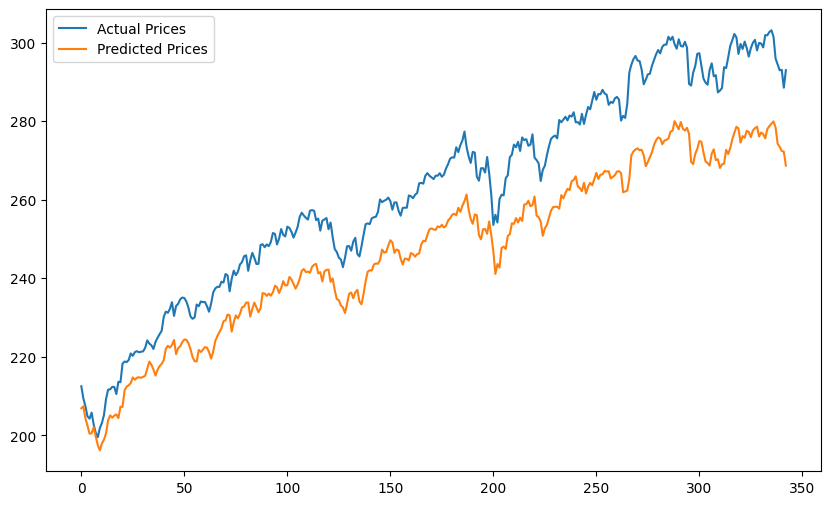

In [23]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(actual_prices[:, 0], label="Actual Prices")
plt.plot(predicted_prices[:, 0], label="Predicted Prices")
plt.legend()
plt.show()

## Observation

LSTM model is returning a **shifted version of the input**. Depending on the nature of the dataset, there simply might be no pattern to be discovered in the data at all.
* In the case of stock data, it is (at least at this scale) completely random, there is equal probability of moving up or down, and hence the model predicts that it will stay the exact same. The model, in a sense, learned that the best way to play is to not play at all :)
* LSTM is finding that by repeating the last value, the loss error achieved is the minimum. But at the cost of not learning any pattern!

We can reduce the similarity between t+1 and t by using a more agressive dropout, adding more data, or try simpler, less overparameterized models. However, the similarity between t+1 and t is still there.

A suggestion from Stack Overflow is to learn the return/delta/difference between times (instead of actual value) and then predict the DIRECTION at t+1 - which turns the problem to CLASSIFICATION, to predict price at t+1 is UP, SAME, or DOWN.

## References
1. https://github.com/jinglescode/time-series-forecasting-pytorch